Detect and track developing DCCs in GOES-16 ABI data

In [87]:
import os
import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from scipy import ndimage as ndi
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


In [2]:
from tobac_flow.dataloader import goes_dataloader
from tobac_flow.flow import create_flow
from tobac_flow.utils import labeled_comprehension
from tobac_flow.analysis import (
    find_object_lengths, remap_labels, mask_labels
)
from tobac_flow.detection import get_curvature_filter, get_growth_rate
from tobac_flow.label import slice_labels
from tobac_flow.plotting import goes_figure

ncdump [-c|-h] [-v ...] [[-b|-f] [c|f]] [-l len] [-n name] [-p n[,n]] [-k] [-x] [-s] [-t|-i] [-g ...] [-w] [-Ln] file
  [-c]             Coordinate variable data and header information
  [-h]             Header information only, no data
  [-v var1[,...]]  Data for variable(s) <var1>,... only
  [-b [c|f]]       Brief annotations for C or Fortran indices in data
  [-f [c|f]]       Full annotations for C or Fortran indices in data
  [-l len]         Line length maximum in data section (default 80)
  [-n name]        Name for netCDF (default derived from file name)
  [-p n[,n]]       Display floating-point values with less precision
  [-k]             Output kind of netCDF file
  [-s]             Output special (virtual) attributes
  [-t]             Output time data as date-time strings
  [-i]             Output time data as date-time strings with ISO-8601 'T' separator
  [-g grp1[,...]]  Data and metadata for group(s) <grp1>,... only
  [-w]             With client-side caching of variabl

In [3]:
# Setup input args

hours = 8

start_date = datetime(2018, 6, 19, 16)
end_date = start_date + timedelta(hours=hours)

satellite = 16

x0 = 1300
x1 = 1600
y0 = 600
y1 = 900

t_offset = 3

save_dir = "../data/dcc_detect"
if not os.path.isdir(save_dir):
    try:
        os.makedirs(save_dir)
    except (FileExistsError, OSError):
        pass

save_name = 'detected_dccs_G%02d_S%s_E%s_X%04d_%04d_Y%04d_%04d.nc' % \
    (satellite, start_date.strftime('%Y%m%d_%H0000'), end_date.strftime('%Y%m%d_%H0000'),
     x0, x1, y0, y1)

save_path = os.path.join(save_dir, save_name)

print("Saving output to:", save_path)

goes_data_path = "../data/GOES16/"
if not os.path.isdir(goes_data_path):
    try:
        os.makedirs(goes_data_path)
    except (FileExistsError, OSError):
        pass


Saving output to: ../data/dcc_detect/detected_dccs_G16_S20180619_160000_E20180620_000000_X1300_1600_Y0600_0900.nc


In [4]:
# Load ABI data
io_kwargs = {'satellite':satellite,
             'product':'MCMIP',
             'view':'C',
             'mode':[3,4,6],
             'save_dir':goes_data_path,
             'replicate_path':True,
             'check_download':True,
             'n_attempts':1,
             'download_missing':True}

bt, wvd, swd, dataset = goes_dataloader(
    start_date, end_date, n_pad_files=t_offset+1, x0=x0, x1=x1, y0=y0, y1=y1, return_new_ds=True, **io_kwargs
)

Loading 104 files
Loaded 104 time steps


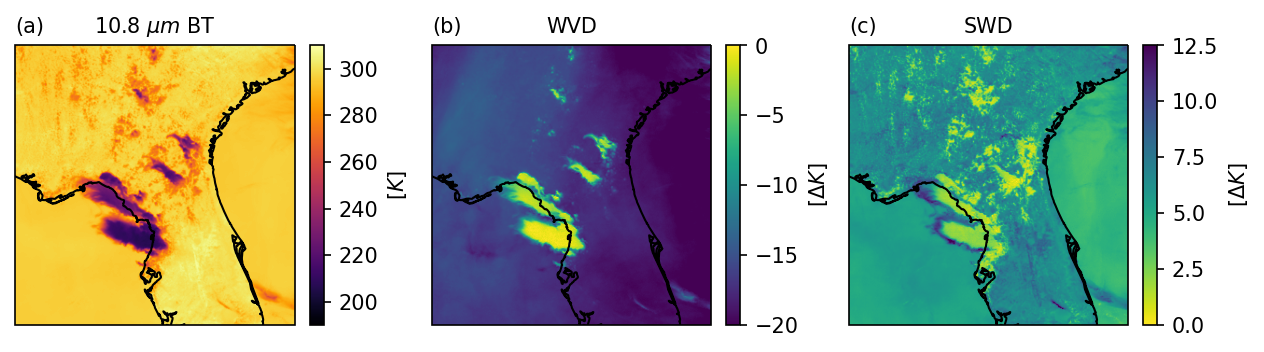

In [5]:
fig = goes_figure(dataset, dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[36], cmap="viridis", vmin=-20, vmax=0)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[36], cmap="viridis_r", vmin=0, vmax=12.5)
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

plt.subplots_adjust(hspace=0.1, bottom=0.1, top=0.85, left=0.075, right=0.95)

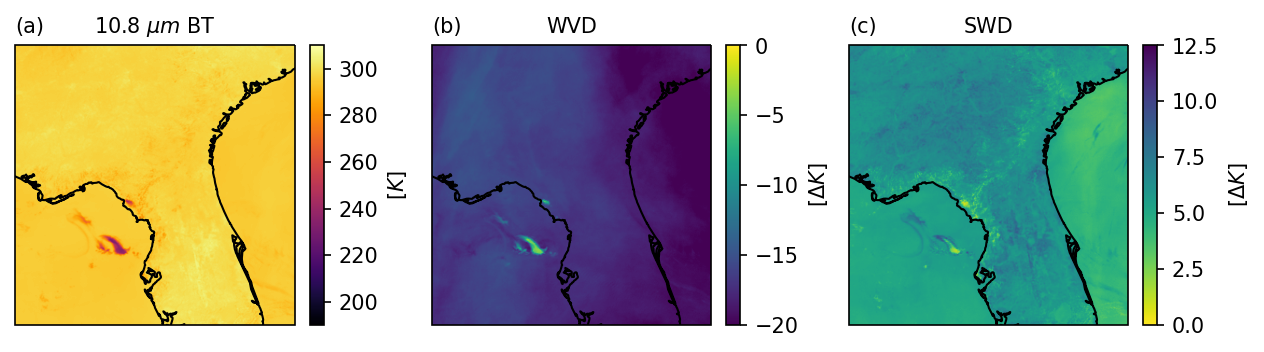

In [6]:
fig = goes_figure(dataset, dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[0], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[0], cmap="viridis", vmin=-20, vmax=0)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[0], cmap="viridis_r", vmin=0, vmax=12.5)
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

plt.subplots_adjust(hspace=0.1, bottom=0.1, top=0.85, left=0.075, right=0.95)

In [7]:
# Generate flow field
flow = create_flow(bt, model="Farneback", vr_steps=1, smoothing_passes=1)

Text(0, 0.5, 'Distance along y axis [km]')

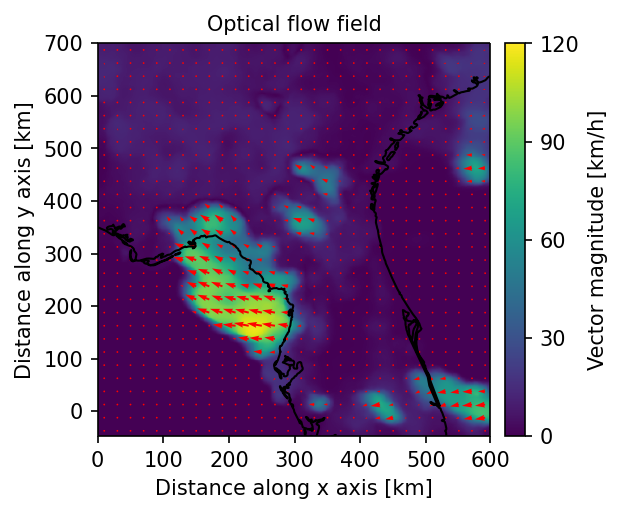

In [8]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

i=36
j=6

ax = fig.subplot(111)
ax.coastlines()
flow_magnitude = ((flow.forward_flow[i:i+j-1,...,0].mean(0)*2.5)**2 
                  + (flow.forward_flow[i:i+j-1,...,1].mean(0)*2)**2)**0.5 * 12
img = ax.imshow(flow_magnitude, vmin=0, vmax=120)
cbar = ax.colorbar(img)
cbar.set_label('Vector magnitude [km/h]', fontsize=10)
cbar.set_ticks([0,30,60,90,120])
q = ax.quiver(
    flow.forward_flow[i:i+j-1,...,0].mean(0), -flow.forward_flow[i:i+j-1,...,1].mean(0), 
    spacing=10, scale=100, width=0.005, color='r'
)
ax.set_title('Optical flow field', fontsize=10)
ax.set_xticks((bt.x*dataset.goes_imager_projection.perspective_point_height)[list(range(0,bt.x.size,50))+[-1]])
ax.set_xticklabels(np.arange(0,bt.x.size+1,50)*2)
ax.set_xlabel("Distance along x axis [km]", fontsize=10)
ax.set_yticks((bt.y*dataset.goes_imager_projection.perspective_point_height)[list(range(0,bt.y.size,40))])
ax.set_yticklabels((np.arange(0,bt.y.size+1,40)[::-1]*2.5).astype(int))
ax.set_ylabel("Distance along y axis [km]", fontsize=10)


In [9]:
# Calculate growth fields
wvd_growth = get_growth_rate(flow, wvd)
bt_growth = get_growth_rate(flow, bt)

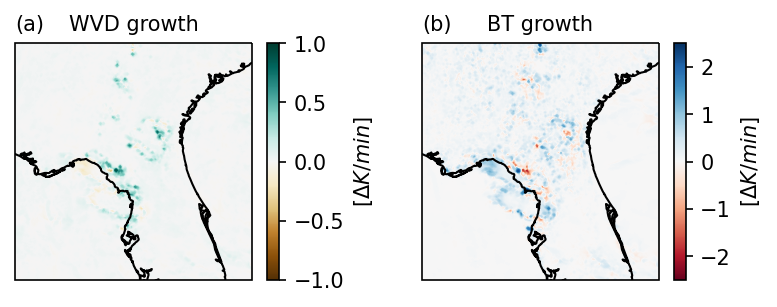

In [10]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(121)
ax1.coastlines()
im1 = ax1.imshow(wvd_growth[36], cmap="BrBG", vmax=1, vmin=-1)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$\Delta K/min$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('WVD growth', fontsize=10)

ax2 = fig.subplot(122)
ax2.coastlines()
im2 = ax2.imshow(bt_growth[36], cmap="RdBu", vmin=-2.5, vmax=2.5)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K/min$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('BT growth', fontsize=10)

plt.subplots_adjust(wspace=0.4)

In [11]:
# Calculate curvature filters and detect cores
wvd_curvature_filter = get_curvature_filter(wvd, direction="negative")
bt_curvature_filter = get_curvature_filter(bt, direction="positive")

wvd_threshold = 0.25
bt_threshold = 0.25

wvd_markers = np.logical_and(
    wvd_growth > wvd_threshold, wvd_curvature_filter
)
bt_markers =  np.logical_and(
    bt_growth  < -bt_threshold, bt_curvature_filter
)

s_struct = ndi.generate_binary_structure(3,1)
s_struct *= np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

combined_markers = ndi.binary_opening(
    np.logical_or(wvd_markers, bt_markers), structure=s_struct
)

print('WVD growth above threshold: area =', np.sum(wvd_markers))
print('BT growth above threshold: area =', np.sum(bt_markers))
print('Detected markers: area =', np.sum(combined_markers))

overlap = 0.5
subsegment_shrink = 0.

core_labels = flow.label(
    combined_markers, overlap=overlap, subsegment_shrink=subsegment_shrink
)

print("Initial core count:", np.max(core_labels))

# Filter labels by length and wvd growth threshold
core_label_lengths = find_object_lengths(core_labels)

print("Core labels meeting length threshold:", np.sum(core_label_lengths>t_offset))

core_label_wvd_mask = mask_labels(core_labels, wvd_growth > wvd_threshold)

print("Core labels meeting WVD growth threshold:", np.sum(core_label_wvd_mask))

combined_mask = np.logical_and(core_label_lengths>t_offset, core_label_wvd_mask)

core_labels = remap_labels(core_labels, combined_mask)

core_step_labels = slice_labels(core_labels)

mode = lambda x : stats.mode(x, keepdims=False)[0]
core_step_core_index = labeled_comprehension(
    core_labels, core_step_labels, mode, default=0
)

core_step_bt_mean = labeled_comprehension(
    bt, core_step_labels, np.nanmean, default=np.nan
)

core_step_t = labeled_comprehension(
    bt.t.data[:, np.newaxis, np.newaxis], core_step_labels, np.nanmin, default=0
)

def bt_diff_func(step_bt, pos):
    step_t = core_step_t[pos]
    args = np.argsort(step_t)

    step_bt = step_bt[args]
    step_t = step_t[args]
    
    step_bt_diff = (
        (step_bt[:-t_offset] - step_bt[t_offset:])
         / ((step_t[t_offset:] - step_t[:-t_offset]).astype("timedelta64[s]").astype("int")/60)
    )

    return np.nanmax(step_bt_diff)

core_bt_diff_mean = labeled_comprehension(
    core_step_bt_mean, core_step_core_index, bt_diff_func, default=0, pass_positions=True
)

wh_valid_core = core_bt_diff_mean>=0.5

core_labels = remap_labels(core_labels, wh_valid_core)

print('Final detected core count: n =', core_labels.max())


WVD growth above threshold: area = 21318
BT growth above threshold: area = 25179
Detected markers: area = 21228
Initial core count: 456
Core labels meeting length threshold: 96
Core labels meeting WVD growth threshold: 357
Final detected core count: n = 91


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

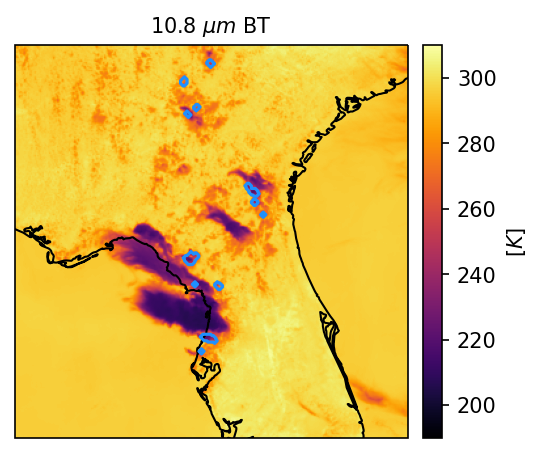

In [12]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.contour(core_labels[36], [0.5], colors=["dodgerblue"])
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)


In [13]:
# Get Nexrad data
if os.path.exists('../data/nexrad_regrid_v2.nc'):
    with xr.open_dataset('../data/nexrad_regrid_v2.nc') as ref_ds:
        ref_grid = ref_ds.ref_grid
        ref_mask = ref_ds.ref_grid
else:
    from tobac_flow import nexrad, io
    nexrad_data_path = '../data/nexrad_l2'
    print('Finding NEXRAD data')
    nexrad_sites = nexrad.filter_nexrad_sites(dataset, extend=0.001)
    print("Number of sites in bound: %d" % len(nexrad_sites))
    dates = pd.date_range(start_date, end_date, freq="h", inclusive="left")
    nexrad_files = sum([sum([io.find_nexrad_files(date, site, save_dir=nexrad_data_path, download_missing=True)
                             for site in nexrad_sites], [])
                        for date in dates], [])
    print(f"Loading {len(nexrad_files)} NEXRAD files")
    # Regrid nexrad - note that this is a lengthly operation, expect it to take ~1 hour for the example here
    # TODO; make pre-processed regridded nexrad file available.
    ref_grid, ref_mask = nexrad.regrid_nexrad(nexrad_files, dataset, min_alt=500)
    ref_ds = xr.Dataset(data_vars={'ref_grid':ref_grid, 'ref_mask':ref_mask})
    ref_ds.to_netcdf('../data/nexrad_regrid_v2.nc')

In [14]:
ref_grid

<xarray.DataArray 'ref_grid' (t: 104, y: 300, x: 300)>
[9360000 values with dtype=float64]
Coordinates:
  * t        (t) datetime64[ns] 2018-06-19T15:43:43.224569984 ... 2018-06-20T...
  * y        (y) float64 0.09461 0.09456 0.0945 ... 0.07798 0.07792 0.07787
  * x        (x) float64 -0.02853 -0.02848 -0.02842 ... -0.01184 -0.01179

Text(0.5, 1.0, 'NEXRAD Column Reflectivity')

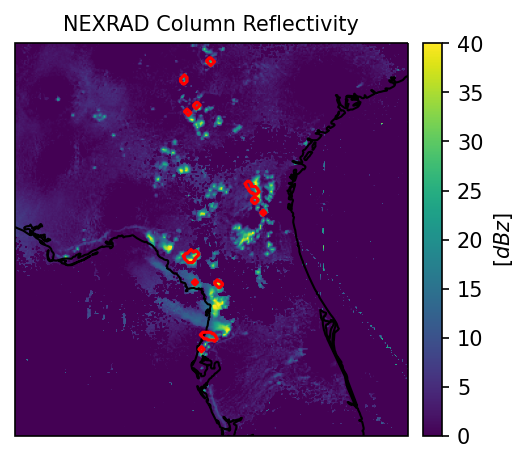

In [15]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(ref_grid[36], cmap="viridis", vmin=0, vmax=40)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$dBz$]', fontsize=10)
ax1.contour(core_labels[36], [0.5], colors=["r"])
ax1.set_title('NEXRAD Column Reflectivity', fontsize=10)


In [47]:
# Detect anvil regions
upper_threshold = -5
lower_threshold = -15
erode_distance = 2

# field = (wvd-(2*np.maximum(swd-5, 0))).data
# field = (wvd-swd).data
# field = wvd.data
# field = np.maximum(np.minimum(field, upper_threshold), lower_threshold)

def linearise_field(field, lower_threshold, upper_threshold):
    if lower_threshold > upper_threshold:
        upper_threshold, lower_threshold = lower_threshold, upper_threshold
    return np.maximum(np.minimum((field - lower_threshold) / (upper_threshold-lower_threshold), 1), 0)

field = linearise_field(
    (wvd-(2*np.maximum(swd-5, 0))).data, 
    lower_threshold, upper_threshold
)

structure = ndi.generate_binary_structure(3,1)
s_struct = structure * np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

# markers = np.logical_or(field>=upper_threshold, core_labels!=0)
markers = field>=1
markers = ndi.binary_erosion(markers, structure=s_struct)
field[markers] = 1
mask = ndi.binary_erosion(
    field<=0, structure=np.ones([3,3,3]),
    iterations=erode_distance, border_value=1
)

edges = flow.sobel(field, direction='uphill', method='linear')

Text(0.5, 1.0, 'Field')

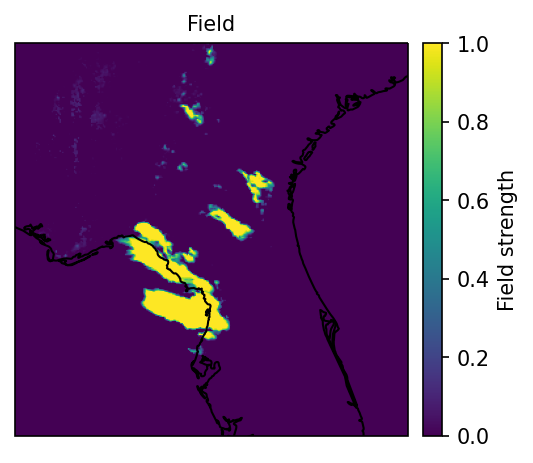

In [52]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(field[36], cmap="viridis", vmin=0, vmax=1)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Field strength', fontsize=10)
ax1.set_title('Field', fontsize=10)


Text(0.5, 1.0, 'Edges')

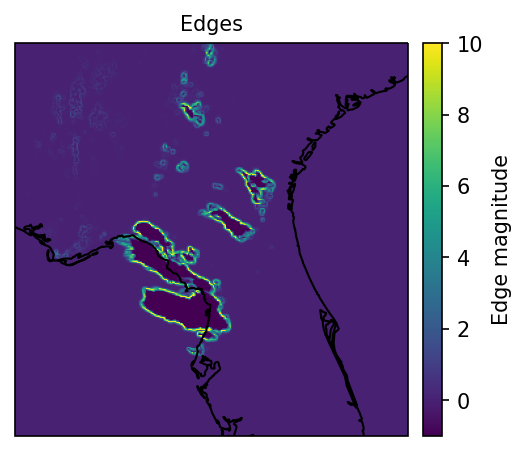

In [51]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(edges[36]-field[36], cmap="viridis", vmin=-1, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Edge magnitude', fontsize=10)
ax1.set_title('Edges', fontsize=10)


In [53]:
marker_labels = flow.label(
    markers, overlap=overlap, subsegment_shrink=subsegment_shrink
)

print('Initial detected thick anvils: area =', np.sum(marker_labels!=0), flush=True)
print('Initial detected thick anvils: n =', marker_labels.max(), flush=True)

marker_label_lengths = find_object_lengths(marker_labels)
marker_label_threshold = mask_labels(marker_labels, core_labels!=0)

marker_labels = remap_labels(
    marker_labels,
    np.logical_and(marker_label_lengths>t_offset, marker_label_threshold)
)

print('Final detected thick anvils: area =', np.sum(marker_labels!=0), flush=True)
print('Final detected thick anvils: n =', marker_labels.max(), flush=True)


Initial detected thick anvils: area = 401040
Initial detected thick anvils: n = 216
Final detected thick anvils: area = 400367
Final detected thick anvils: n = 16


Text(0.5, 1.0, 'Edges')

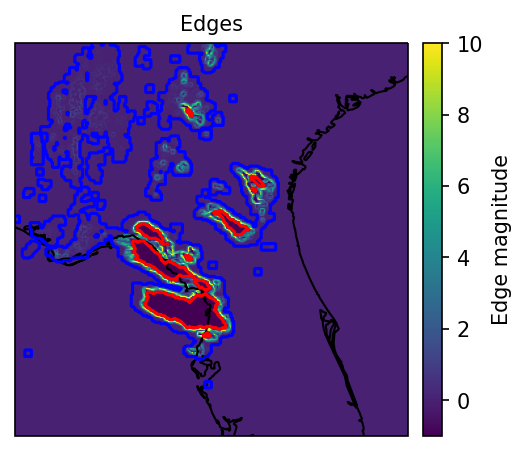

In [54]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(edges[36]-field[36], cmap="viridis", vmin=-1, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Edge magnitude', fontsize=10)
ax1.contour(marker_labels[36], [0.5], colors=["r"])
ax1.contour(mask[36], [0.5], colors=["b"])
ax1.set_title('Edges', fontsize=10)


In [56]:
test_watershed = flow.watershed(edges-field, marker_labels, mask=mask, structure=structure)

In [58]:
test_watershed.max()

16

Text(0.5, 1.0, '10.8 $\\mu m$ BT')

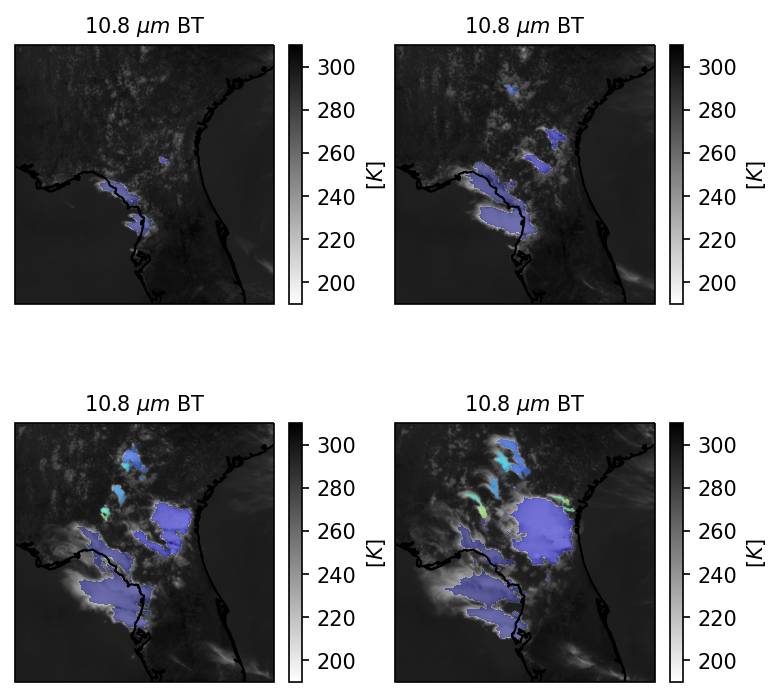

In [57]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed, mask=test_watershed==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed, mask=test_watershed==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[48], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed, mask=test_watershed==0)[48], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[60], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed, mask=test_watershed==0)[60], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

In [59]:
from scipy import ndimage as ndi
from tobac_flow.label import flat_label, relabel_objects
def make_step_labels(labels):
    step_labels = flat_label(labels!=0)
    step_labels += labels * step_labels.max()
    return relabel_objects(step_labels)

In [66]:
test_step_watershed = make_step_labels(test_watershed)

Text(0.5, 1.0, '10.8 $\\mu m$ BT')

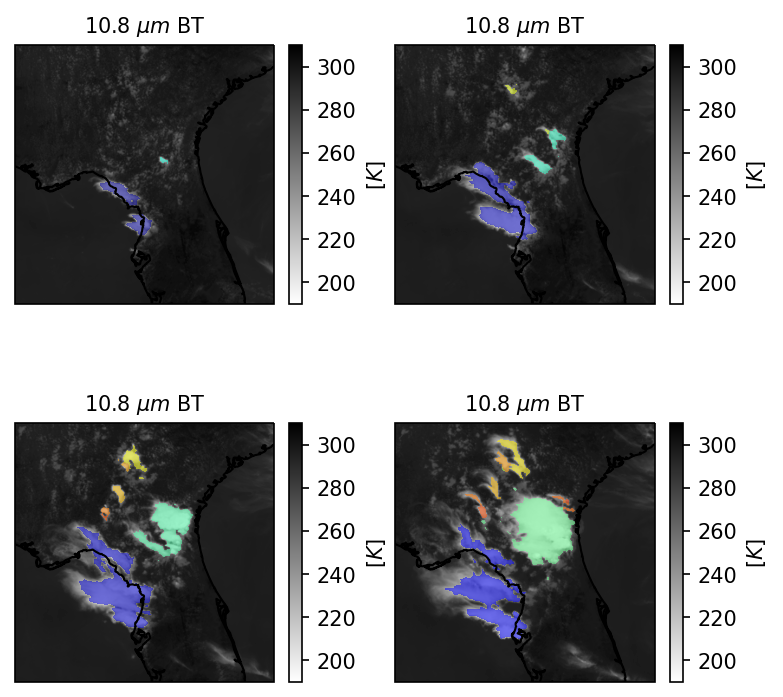

In [68]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_step_watershed, mask=test_step_watershed==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=test_step_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_step_watershed, mask=test_step_watershed==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=test_step_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[48], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_step_watershed, mask=test_step_watershed==0)[48], cmap="jet", alpha=0.5, vmin=1, vmax=test_step_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[60], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_step_watershed, mask=test_step_watershed==0)[60], cmap="jet", alpha=0.5, vmin=1, vmax=test_step_watershed.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

In [71]:
# implement minimum overlap for flow_label function
import warnings
from tobac_flow.label import find_neighbour_labels 
def flow_link_overlap(
    flow,
    flat_labels,
    structure=ndi.generate_binary_structure(3, 1),
    dtype=np.int32,
    overlap=0.0,
    subsegment_shrink=0.0,
    peak_min_distance=10,
):
    """
    Label 3d connected objects in a semi-Lagrangian reference frame

    Parameters
    ----------
    flow : tobac_flow.Flow object
        The flow-field object corresponding to the mask being labelled
    mask : numpy.ndarray
        A 3d array of in which non-zero values are treated as regions to be
        labelled
    structure : numpy.ndarray - optional
        A (3,3,3) boolean array defining the connectivity between each point
        and its neighbours. Defaults to square connectivity
    dtype : dtype - optional
        Dtype for the returned labelled array. Defaults to np.int32
    overlap : float - optional
        The required minimum overlap between subsequent labels (when accounting
            for Lagrangian motion) to consider them a continous object. Defaults
            to 0.
    subsegment_shrink : float - optional
        The proportion of each regions approximate radius to shrink it by when
            performing subsegmentation. If 0 subsegmentation will not be
            performed. Defaults to 0.
    peak_min_distance : int - optional
        The minimum distance between maxima allowed when performing
            subsegmentation. Defaults to 5
    """
    label_struct = structure * np.array([1, 0, 1])[:, np.newaxis, np.newaxis]

    back_labels, forward_labels = flow.convolve(
        flat_labels, method="nearest", dtype=dtype, structure=label_struct
    )

    bins = np.cumsum(np.bincount(flat_labels.ravel()))
    args = np.argsort(flat_labels.ravel())

    processed_labels = np.zeros(bins.size, dtype=bool)
    label_map = {}

    for label in range(1, bins.size):
        if not processed_labels[label]:
            label_map[label] = [label]
            processed_labels[label] = True

            i = 0
            while i < len(label_map[label]):
                find_neighbour_labels(
                    label_map[label][i],
                    label_map[label],
                    bins,
                    args,
                    processed_labels,
                    forward_labels,
                    back_labels,
                    overlap=overlap,
                )
                i += 1

    new_labels = np.zeros(mask.shape, dtype=dtype)

    for ik, k in enumerate(label_map):
        for i in label_map[k]:
            if bins[i] > bins[i - 1]:
                new_labels.ravel()[args[bins[i - 1] : bins[i]]] = ik + 1

    if not np.all(new_labels.astype(bool) == mask.astype(bool)):
        # This may occur if subsegmentation is over zealous
        warnings.warn("Not all regions present in labeled array", RuntimeWarning)
    return new_labels


In [76]:
test_watershed_linked = flow_link_overlap(flow, test_step_watershed, overlap=0.5)

marker_label_lengths = find_object_lengths(test_watershed_linked)
marker_label_threshold = mask_labels(test_watershed_linked, core_labels!=0)

test_watershed_linked = remap_labels(
    test_watershed_linked,
    np.logical_and(marker_label_lengths>t_offset, marker_label_threshold)
)

print('Final detected thick anvils: area =', np.sum(test_watershed_linked!=0), flush=True)
print('Final detected thick anvils: n =', test_watershed_linked.max(), flush=True)


Final detected thick anvils: area = 712809
Final detected thick anvils: n = 12


/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_552/685311810.py:80: RuntimeWarning: Not all regions present in labeled array
  warnings.warn("Not all regions present in labeled array", RuntimeWarning)


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

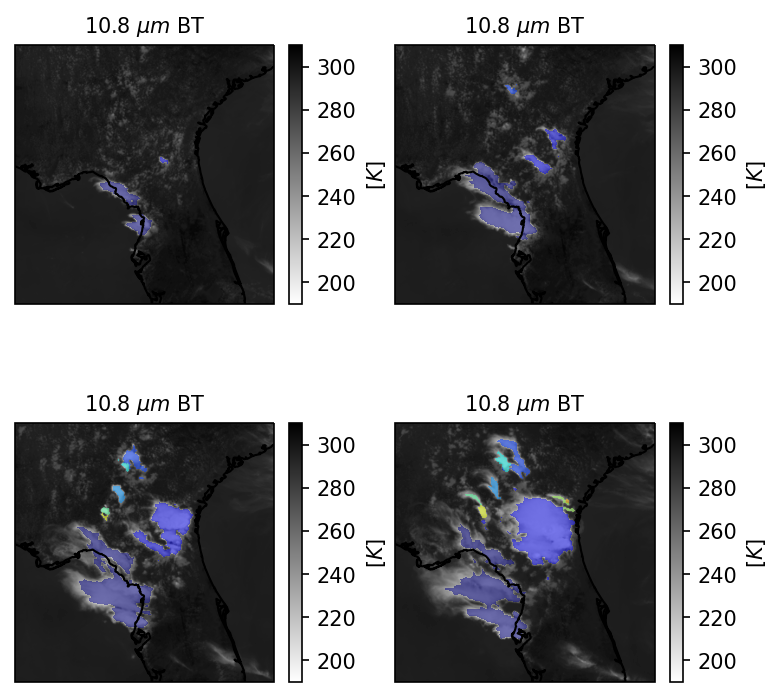

In [77]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed_linked[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed_linked, mask=test_watershed_linked==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed_linked.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed_linked[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed_linked, mask=test_watershed_linked==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed_linked.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[48], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed_linked[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed_linked, mask=test_watershed_linked==0)[48], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed_linked.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[60], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed_linked[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_watershed_linked, mask=test_watershed_linked==0)[60], cmap="jet", alpha=0.5, vmin=1, vmax=test_watershed_linked.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

In [80]:
# Detect anvil regions
upper_threshold = -5
lower_threshold = -15
erode_distance = 2

# field = (wvd-(2*np.maximum(swd-5, 0))).data
# field = (wvd-swd).data
# field = wvd.data
# field = np.maximum(np.minimum(field, upper_threshold), lower_threshold)

def linearise_field(field, lower_threshold, upper_threshold):
    if lower_threshold > upper_threshold:
        upper_threshold, lower_threshold = lower_threshold, upper_threshold
    return np.maximum(np.minimum((field - lower_threshold) / (upper_threshold-lower_threshold), 1), 0)

field = linearise_field(
    (wvd+(2*np.maximum(swd-5, 0))).data, 
    lower_threshold, upper_threshold
)

structure = ndi.generate_binary_structure(3,1)
s_struct = structure * np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

# markers = np.logical_or(field>=upper_threshold, core_labels!=0)
markers = test_watershed_linked
markers *= ndi.binary_erosion(markers!=0, structure=s_struct).astype(int)
field[markers!=0] = 1

mask = ndi.binary_erosion(
    field<=0, structure=np.ones([3,3,3]),
    iterations=erode_distance, border_value=1
)

edges = flow.sobel(field, direction='uphill', method='linear')

Text(0.5, 1.0, 'Edges')

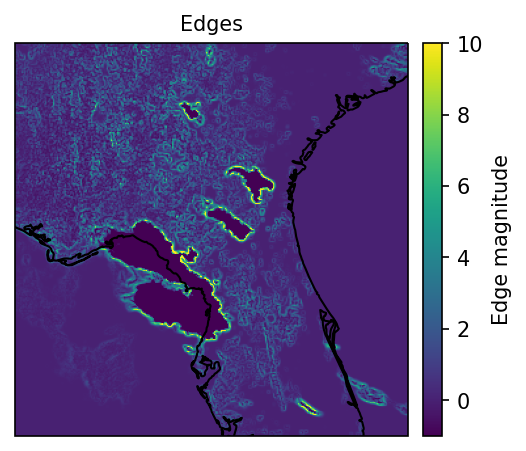

In [81]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(edges[36]-field[36], cmap="viridis", vmin=-1, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Edge magnitude', fontsize=10)
ax1.set_title('Edges', fontsize=10)


In [82]:
test_thin_anvil_labels = flow.watershed(edges, markers, mask=mask,
                                   structure=structure)

test_thin_anvil_labels *= ndi.binary_opening(test_thin_anvil_labels, structure=s_struct).astype(int)

print('Detected thin anvils: area =', np.sum(test_thin_anvil_labels!=0), flush=True)
print('Detected thin anvils: n =', np.max(test_thin_anvil_labels), flush=True)


Detected thin anvils: area = 1341685
Detected thin anvils: n = 12


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

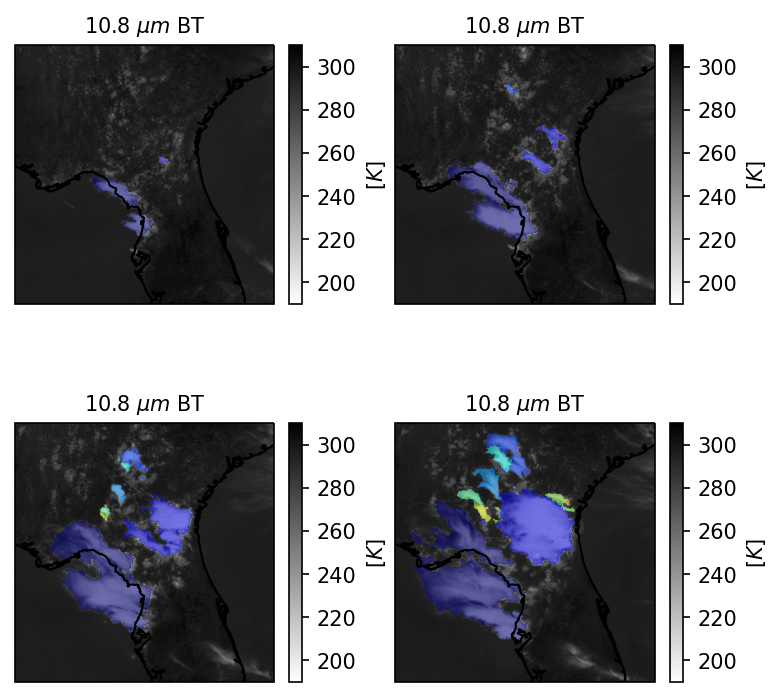

In [83]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_thin_anvil_labels, mask=test_thin_anvil_labels==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=test_thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_thin_anvil_labels, mask=test_thin_anvil_labels==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=test_thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[48], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_thin_anvil_labels, mask=test_thin_anvil_labels==0)[48], cmap="jet", alpha=0.5, vmin=1, vmax=test_thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[60], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(test_thin_anvil_labels, mask=test_thin_anvil_labels==0)[60], cmap="jet", alpha=0.5, vmin=1, vmax=test_thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

Text(0.5, 1.0, 'SWD BT difference')

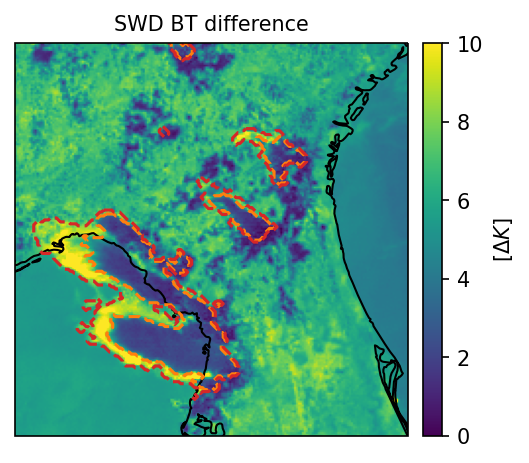

In [85]:
fig = goes_figure(dataset.isel(x=slice(50,250), y=slice(50,250)), dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(swd[36].isel(x=slice(50,250), y=slice(50,250)), cmap="viridis", vmin=0, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$\Delta K$]', fontsize=10)
ax1.contour(test_watershed_linked[36][50:250, 50:250], [0.5], colors=["C1"], linestyles="--")
ax1.contour(test_thin_anvil_labels[36][50:250, 50:250], [0.5], colors=["C3"], linestyles="--")
ax1.set_title('SWD BT difference', fontsize=10)


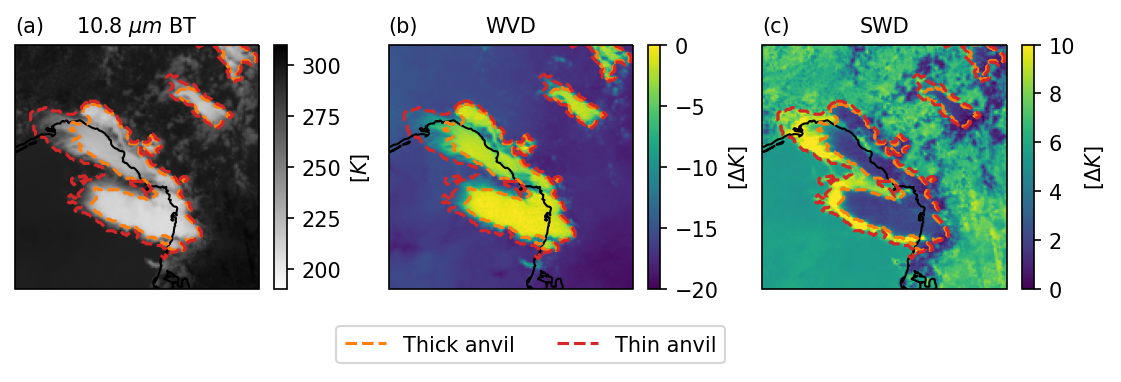

In [88]:
fig = goes_figure(dataset.isel(x=slice(50,200), y=slice(100,250)), dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[36].isel(x=slice(50,200), y=slice(100,250)), cmap="binary", vmin=190, vmax=310)
ax1.contour(test_watershed_linked[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax1.contour(test_thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=-20, vmax=0)
ax2.contour(test_watershed_linked[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax2.contour(test_thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=0, vmax=10)
ax3.contour(test_watershed_linked[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax3.contour(test_thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

fig.legend([mlines.Line2D([], [], color='C1', linestyle="--"), mlines.Line2D([], [], color='C3', linestyle="--")], 
           ['Thick anvil', 'Thin anvil'], loc=[0.3,0.05], ncol=2)

plt.subplots_adjust(wspace=0.25)

In [ ]:
test_thick_anvil_labels = flow.label(
    , overlap=overlap, subsegment_shrink=subsegment_shrink
)

print('Initial detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Initial detected thick anvils: n =', thick_anvil_labels.max(), flush=True)

test_thick_anvil_label_lengths = find_object_lengths(thick_anvil_labels)
test_thick_anvil_label_threshold = mask_labels(thick_anvil_labels, markers)

test_thick_anvil_labels = remap_labels(
    test_thick_anvil_labels,
    np.logical_and(test_thick_anvil_label_lengths>t_offset, test_thick_anvil_label_threshold)
)

print('Final detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Final detected thick anvils: n =', thick_anvil_labels.max(), flush=True)


In [20]:
watershed = flow.watershed(edges, markers, mask=mask, structure=structure)

thick_anvil_labels = flow.label(
    ndi.binary_opening(watershed, structure=s_struct), overlap=overlap, subsegment_shrink=subsegment_shrink
)

print('Initial detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Initial detected thick anvils: n =', thick_anvil_labels.max(), flush=True)

thick_anvil_label_lengths = find_object_lengths(thick_anvil_labels)
thick_anvil_label_threshold = mask_labels(thick_anvil_labels, markers)

thick_anvil_labels = remap_labels(
    thick_anvil_labels,
    np.logical_and(thick_anvil_label_lengths>t_offset, thick_anvil_label_threshold)
)

print('Final detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Final detected thick anvils: n =', thick_anvil_labels.max(), flush=True)


Initial detected thick anvils: area = 681131
Initial detected thick anvils: n = 11
Final detected thick anvils: area = 681067
Final detected thick anvils: n = 6


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

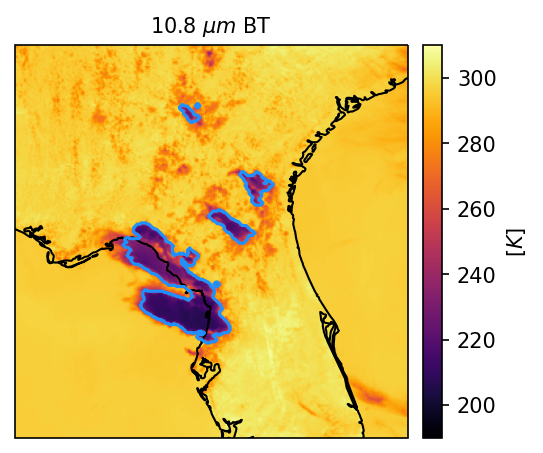

In [21]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

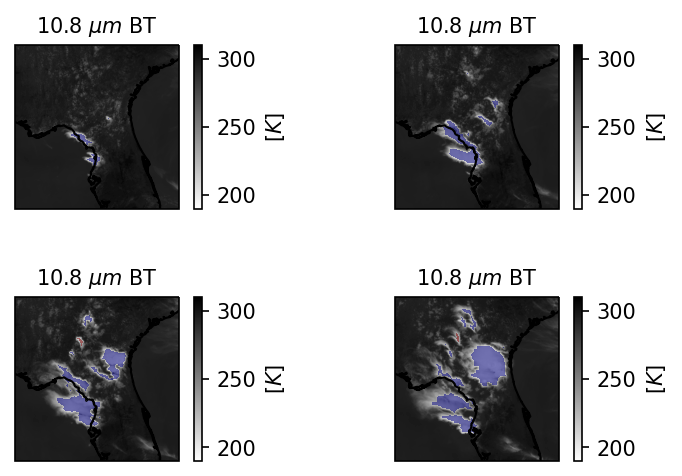

In [38]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[24], cmap="jet", alpha=0.5)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[36], cmap="jet", alpha=0.5)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[48], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[48], cmap="jet", alpha=0.5)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[60], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(test_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[60], cmap="jet", alpha=0.5)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

In [22]:
upper_threshold = -5
lower_threshold = -15

markers = thick_anvil_labels
markers *= ndi.binary_erosion(markers, structure=s_struct).astype(int)

field = (wvd+(2*np.maximum(swd-5, 0))).data
field = np.maximum(np.minimum(field, upper_threshold), lower_threshold)
field[markers!=0] = upper_threshold

mask = ndi.binary_erosion(
    field<=lower_threshold, structure=np.ones([3,3,3]),
    iterations=erode_distance, border_value=1
)

edges = flow.sobel(field, direction='uphill', method='linear')

thin_anvil_labels = flow.watershed(edges, markers, mask=mask,
                                   structure=structure)

thin_anvil_labels *= ndi.binary_opening(thin_anvil_labels, structure=s_struct).astype(int)

print('Detected thin anvils: area =', np.sum(thin_anvil_labels!=0), flush=True)


Detected thin anvils: area = 1333170


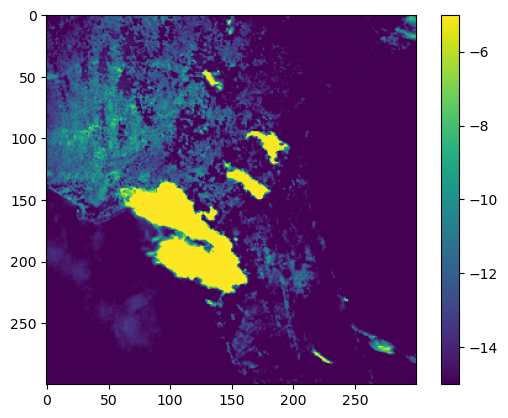

In [155]:

plt.imshow(field[36])
plt.colorbar()

<>:7: DeprecationWarning: invalid escape sequence '\D'
<>:7: DeprecationWarning: invalid escape sequence '\D'
/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_77458/261179377.py:7: DeprecationWarning: invalid escape sequence '\D'
  cbar1.set_label('[$\Delta K$]', fontsize=10)


Text(0.5, 1.0, 'SWD BT difference')

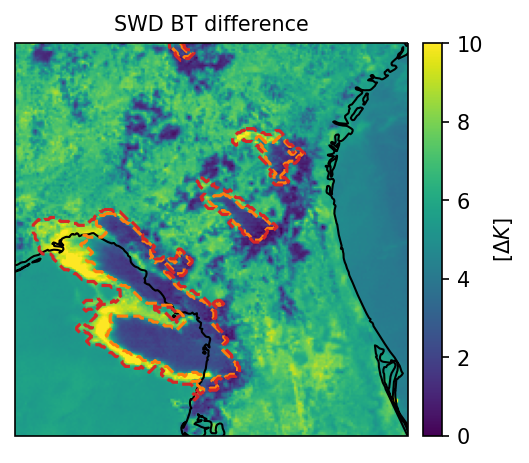

In [157]:
fig = goes_figure(dataset.isel(x=slice(50,250), y=slice(50,250)), dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(swd[36].isel(x=slice(50,250), y=slice(50,250)), cmap="viridis", vmin=0, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$\Delta K$]', fontsize=10)
ax1.contour(thick_anvil_labels[36][50:250, 50:250], [0.5], colors=["C1"], linestyles="--")
ax1.contour(thin_anvil_labels[36][50:250, 50:250], [0.5], colors=["C3"], linestyles="--")
ax1.set_title('SWD BT difference', fontsize=10)


<>:10: DeprecationWarning: invalid escape sequence '\m'
<>:10: DeprecationWarning: invalid escape sequence '\m'
/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_77458/1210977566.py:10: DeprecationWarning: invalid escape sequence '\m'
  ax1.set_title('10.8$\mu m$ BT', fontsize=10)


Text(0.5, 1.0, '10.8$\\mu m$ BT')

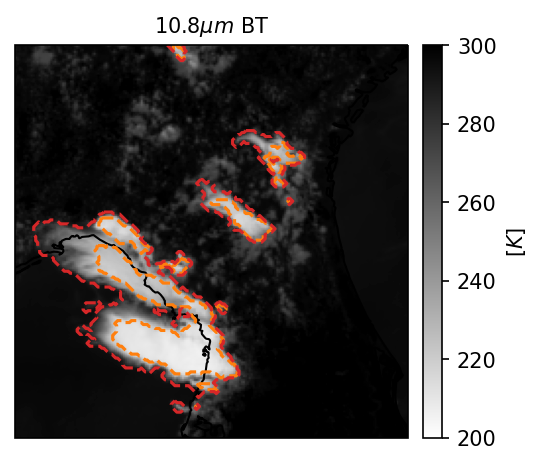

In [128]:
fig = goes_figure(dataset.isel(x=slice(50,250), y=slice(50,250)), dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(bt[36].isel(x=slice(50,250), y=slice(50,250)), cmap="binary", vmin=200, vmax=300)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.contour(thick_anvil_labels[36][50:250, 50:250], [0.5], colors=["C1"], linestyles="--")
ax1.contour(thin_anvil_labels[36][50:250, 50:250], [0.5], colors=["C3"], linestyles="--")
ax1.set_title('10.8$\mu m$ BT', fontsize=10)


<>:11: DeprecationWarning: invalid escape sequence '\m'
<>:19: DeprecationWarning: invalid escape sequence '\D'
<>:29: DeprecationWarning: invalid escape sequence '\D'
<>:11: DeprecationWarning: invalid escape sequence '\m'
<>:19: DeprecationWarning: invalid escape sequence '\D'
<>:29: DeprecationWarning: invalid escape sequence '\D'
/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_77458/1524150406.py:11: DeprecationWarning: invalid escape sequence '\m'
  ax1.set_title('10.8 $\mu m$ BT', fontsize=10)
/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_77458/1524150406.py:19: DeprecationWarning: invalid escape sequence '\D'
  cbar2.set_label('[$\Delta K$]', fontsize=10)
/var/folders/40/kfr98p0j7n30fjp2n4ljjqbh0000gr/T/ipykernel_77458/1524150406.py:29: DeprecationWarning: invalid escape sequence '\D'
  cbar3.set_label('[$\Delta K$]', fontsize=10)


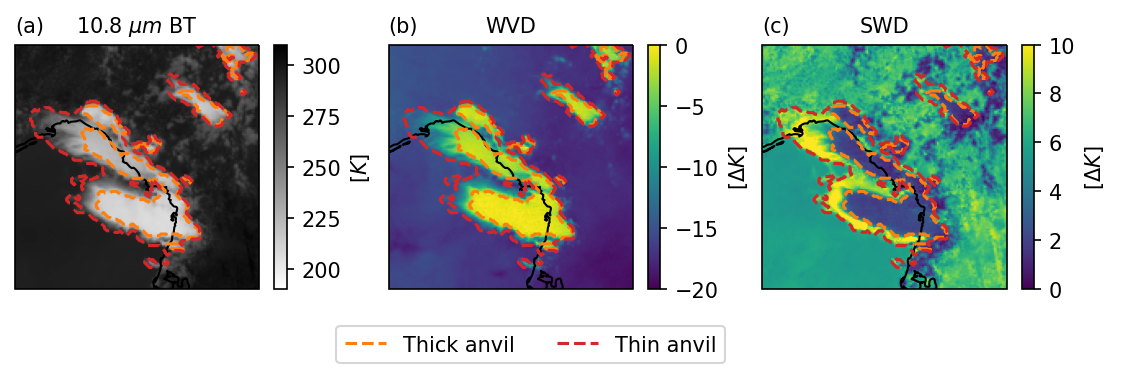

In [129]:
fig = goes_figure(dataset.isel(x=slice(50,200), y=slice(100,250)), dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[36].isel(x=slice(50,200), y=slice(100,250)), cmap="binary", vmin=190, vmax=310)
ax1.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax1.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=-20, vmax=0)
ax2.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax2.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=0, vmax=10)
ax3.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax3.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

fig.legend([mlines.Line2D([], [], color='C1', linestyle="--"), mlines.Line2D([], [], color='C3', linestyle="--")], 
           ['Thick anvil', 'Thin anvil'], loc=[0.3,0.05], ncol=2)

plt.subplots_adjust(wspace=0.25)

In [109]:
fig.legend?

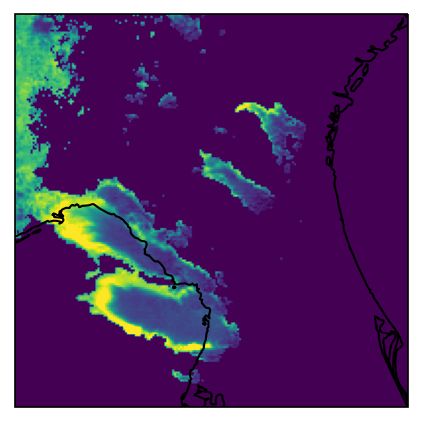

In [94]:
fig = goes_figure(dataset.isel(x=slice(50,250), y=slice(50,250)), dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow((swd[36]*(wvd[36]>-15).astype(float)).isel(x=slice(50,250), y=slice(50,250)), cmap="viridis", vmin=0, vmax=10)


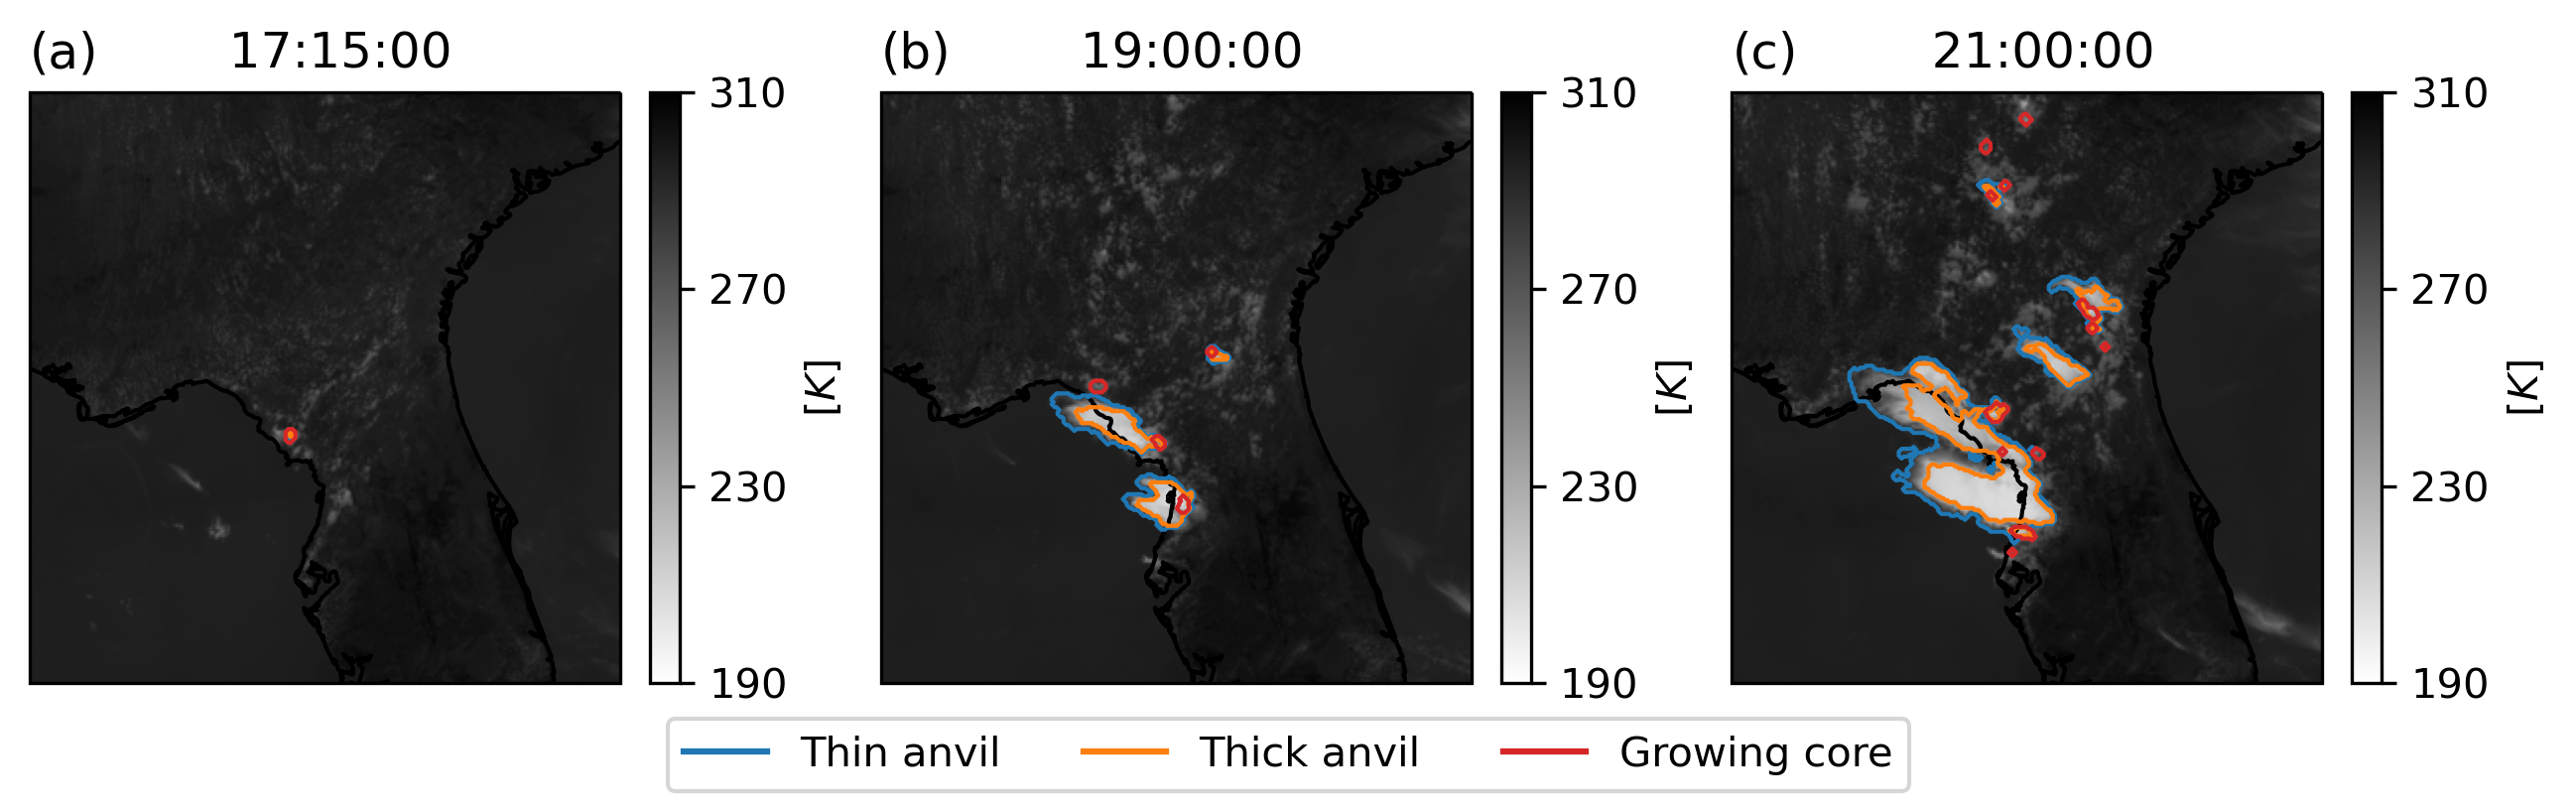

In [83]:
fig = goes_figure(dataset, dpi=300, figsize=(9,3))

i1=12
ax1 = fig.subplot(131)
ax1.coastlines()
img = ax1.imshow(bt[i1], vmin=190, vmax=310, cmap='binary')
cbar = ax1.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax1.set_title('(a)', loc='left')
ax1.set_title('  17:15:00')

ax1.contour(thin_anvil_labels[i1], [0.5], colors=['C00'], linewidths=[1])
ax1.contour(thick_anvil_labels[i1], [0.5], colors=['C01'], linewidths=[1])
ax1.contour(core_labels[i1], [0.5], colors=['C03'], linewidths=[1])

i2=24
ax2 = fig.subplot(132)
ax2.coastlines()
img = ax2.imshow(bt[i2], vmin=190, vmax=310, cmap='binary')
cbar = ax2.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax2.set_title('(b)', loc='left')
ax2.set_title('  19:00:00')

ax2.contour(thin_anvil_labels[i2], [0.5], colors=['C00'], linewidths=[1])
ax2.contour(thick_anvil_labels[i2], [0.5], colors=['C01'], linewidths=[1])
ax2.contour(core_labels[i2], [0.5], colors=['C03'], linewidths=[1])

i3=36
ax3 = fig.subplot(133)
ax3.coastlines()
img = ax3.imshow(bt[i3], vmin=190, vmax=310, cmap='binary')
cbar = ax3.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax3.set_title('(c)', loc='left')
ax3.set_title('  21:00:00')

ax3.contour(thin_anvil_labels[i3], [0.5], colors=['C00'], linewidths=[1])
ax3.contour(thick_anvil_labels[i3], [0.5], colors=['C01'], linewidths=[1])
ax3.contour(core_labels[i3], [0.5], colors=['C03'], linewidths=[1])

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
           ['Thin anvil', 'Thick anvil', 'Growing core'], loc='lower center', ncol=3)

plt.subplots_adjust(bottom=0.05, hspace=0.1, left=0)